# Introduction to Topological Data Analysis with GUDHI

This notebooks shows how to use GUDHI to compute persistence diagrams of some 2D point data using alpha shapes.

In [1]:
import gudhi
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import (collections, tri)

## Generate random points in a conspicuous shape

We start with a set of random points. We suspect there's an underlying shape to this point set, but how to we quantify shape?

In [4]:
N = 50
sigma = 0.2
theta = np.random.uniform(0, 2 * np.pi, N)
radius = np.random.normal(1.0, sigma, (N, 1))
points = radius * np.c_[np.cos(theta), np.sin(theta)]

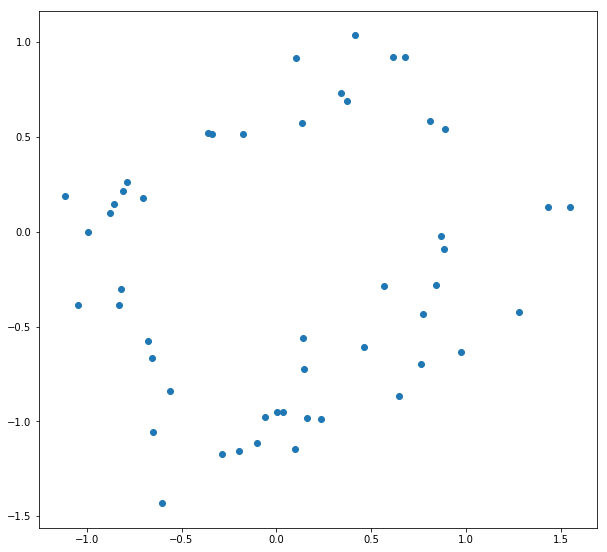

In [5]:
fig, ax = plt.subplots(figsize=(10, 10),subplot_kw={'aspect': 1})
ax.scatter(*points.T)
plt.show()

## Create alpha complex
We now generate alpha shapes from our little point set.

In [6]:
alpha_complex = gudhi.AlphaComplex(points)
simplex_tree = alpha_complex.create_simplex_tree()
simplex_tree.initialize_filtration()
f = simplex_tree.get_filtration()

The structure of the returned filtration is

```python
[([idx0, idx1, ...], alpha), ...]
```

Vertices have an index list of length 1, edges have an index list of length 2, etc. We'll need some helper functions to get to the simplices in the alpha complex.

In [7]:
def sub_filtration(filtration, alpha):
    return [f for f in filtration if f[1] < alpha]

def filtration_vertices(filtration):
    return np.array([f[0][0] for f in filtration if len(f[0]) == 1])

def filtration_edges(filtration):
    return np.array([f[0] for f in filtration if len(f[0]) == 2])

def filtration_triangles(filtration):
    return np.array([f[0] for f in filtration if len(f[0]) == 3])

Now we can plot the alpha-complex as a function of alpha.

In [8]:
def plot_alpha_shape(points, filtration, alpha, show_balls=False):
    f_sub = sub_filtration(filtration, alpha)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 1})
    
    # plot edges
    edges = filtration_edges(f_sub)
    if edges is not None and edges.size > 0:
        lines = collections.LineCollection(points[edges], color='k')
        ax.add_collection(lines)

    # plot triangles
    triangles = filtration_triangles(f_sub)
    if triangles is not None and triangles.size > 0:
        colors = np.ones(len(triangles))
        ax.tripcolor(
            points[:,0], points[:,1], triangles, alpha=0.3,
            facecolors=colors)
    
    # show balls
    if show_balls:
        radius = np.ones(len(points)) * np.sqrt(alpha)
        angles = np.zeros(len(points))
        circles = collections.EllipseCollection(
            radius*2, radius*2, angles, offsets=points, units='xy',
            transOffset=ax.transData, alpha=1.0, color='#ffd0d0', zorder=0)
        ax.add_collection(circles, autolim=True)
        
    # plot vertices        
    ax.scatter(*points.T, c='k', zorder=5)
   
    plt.show()

In [9]:
from ipywidgets import interactive
interactive_plot = interactive(
    lambda sqrt_alpha, show_balls: plot_alpha_shape(
        points, f, sqrt_alpha**2, show_balls),
    sqrt_alpha=(0.0,0.7,0.01), show_balls=False)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot.children[0].description = '√α'
interactive_plot.children[1].description = 'show some balls'
interactive_plot

interactive(children=(FloatSlider(value=0.35000000000000003, description='√α', max=0.7, step=0.01), Checkbox(v…

Growing balls around the points in the point set, we see that the topology of the triangulation changes

## Persistence diagram

In [10]:
p = simplex_tree.persistence()
max_p = np.array([j[1] for j in p if j[0] == 1])[:,1].max()

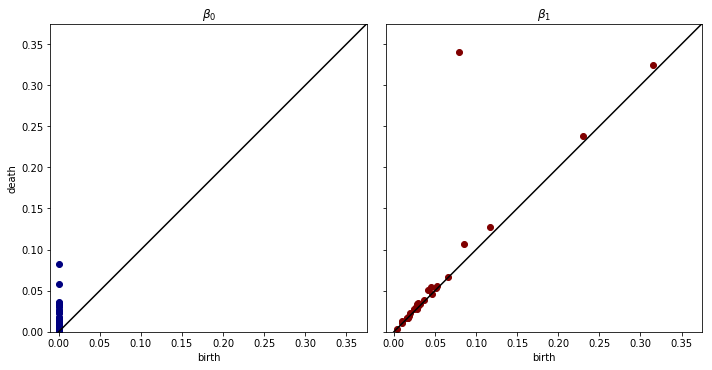

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,10), sharey=True, subplot_kw={'aspect': 1})

for i in range(2):
    birth, death = np.array([j[1] for j in p if j[0] == i]).T
    ax[i].scatter(birth, death, c=['navy', 'maroon'][i])
    ax[i].plot([0, 1.1*max_p], [0, 1.1*max_p], 'k-')
    ax[i].set_title('$\\beta_{}$'.format(i))
    
    ax[i].set_xlim([-0.01, 1.1*max_p])
    ax[i].set_ylim([-0, 1.1*max_p])

    ax[i].set_xlabel('birth')
    if i == 0:
        ax[i].set_ylabel('death')

fig.tight_layout()
plt.show()